In [1]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
from scipy.fftpack import dct, idct
%matplotlib inline

In [2]:
class ImageLoader:
    def __init__(self,FILE_PATH):
            self.img = np.array(Image.open(FILE_PATH))
            
    def get_points(self,POINT):
        Row = random.randint(0,len(self.img)-POINT-1)
        Col = random.randint(0,len(self.img)-1)
        return self.img[Row:Row+POINT,Col]

In [3]:
def get_data_simple_connect(data):
    return np.hstack((data,data))

In [4]:
def get_data_even_connect(data):
    return np.hstack((data,data[::-1]))

In [5]:
# ランチョスしたのを返す
def Lanczos(data):
    points = len(data)
    left = int(data[0])
    right = int(data[len(data)-1])
    result = np.zeros(points)

    for i in range(points):
#         result[i] = data[i] - ((right-left)*i/(points-1) + left)
        result[i] = data[i] - ((right-left)*i/(points-1))
    
    return result

In [6]:
class DCT:
    def __init__(self,N):
        self.N = N # データ数
        # 1次元DCTの基底ベクトルの生成
        self.phi_1d = np.array([ self.phi(i) for i in range(self.N)])
        # 2次元DCTの基底ベクトルの格納
        self.phi_2d = np.zeros((N,N))
                
    def phi(self,k):
        """ 離散コサイン変換(DCT)の基底関数 """
        # DCT-II
        if k == 0:
            return np.ones(self.N)/np.sqrt(self.N)
        else:
            return np.sqrt(2.0/self.N)*np.cos((k*np.pi/(2*self.N))*(np.arange(self.N)*2+1))
        
    def dct(self,data):
        """ 1次元離散コサイン変換を行う """
        return self.phi_1d.dot(data)

    def idct(self,c):
        """ 1次元離散コサイン逆変換を行う """
        return np.sum( self.phi_1d.T * c)
    
    def get_dct2_phi(self,i,j):
        """ 2次元離散コサイン変換の基底を返す """
        phi_i,phi_j = np.meshgrid(self.phi_1d[i],self.phi_1d[j])
        return phi_i*phi_j
    
    def get_dct2(self,i,j,data):
        """ i,jの2次元DCT係数を返す """
        phi_2d_phi = np.zeros((self.N,self.N))
        phi_2d_phi = self.get_dct2_phi(i,j)
        return np.sum(phi_2d_phi.reshape(self.N*self.N)*data.reshape(self.N*self.N))
    
    def dct2(self,data):
        """ 2次元離散コサイン変換を行う """
        for j in tqdm(range(self.N)):
            for i in range(self.N):
                self.phi_2d[i,j] = self.get_dct2(i,j,data)
        
        return self.phi_2d
    
    def idct2(self,c):
        """ 2次元離散コサイン逆変換を行う """
        idct2_data = np.zeros((self.N,self.N))
        phi_2d_phi = np.zeros((self.N,self.N))
        for i in tqdm(range(self.N)):
            for j in range(self.N):
                phi_2d_phi = self.get_dct2_phi(j,i)
                idct2_data += c.reshape((self.N,self.N,1))[j,i]*phi_2d_phi
        
        return idct2_data

In [7]:
# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams['font.family'] ='Source Han Sans JP' #使用するフォント
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
plt.rcParams['font.size'] = 12 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

# 画像の用意

In [8]:
AIRPLANE   = ImageLoader("Mono/Airplane.bmp")
BARBARA    = ImageLoader("Mono/BARBARA.bmp")
BOAT       = ImageLoader("Mono/BOAT.bmp")
BRIDGE     = ImageLoader("Mono/BRIDGE.bmp")
BUILDING   = ImageLoader("Mono/Building.bmp")
CAMERAMAN  = ImageLoader("Mono/Cameraman.bmp")
GIRL       = ImageLoader("Mono/girl.bmp")
LAX        = ImageLoader("Mono/LAX.bmp")
LENNA      = ImageLoader("Mono/LENNA.bmp")
LIGHTHOUSE = ImageLoader("Mono/Lighthouse.bmp")
SIDBAtitle = ImageLoader("Mono/SIDBAtitle256.bmp")
TEXT       = ImageLoader("Mono/Text.bmp")
WOMAN      = ImageLoader("Mono/WOMAN.bmp")

In [9]:
Images = np.array(
    [
        AIRPLANE,BARBARA,BOAT,
        BRIDGE,BUILDING,CAMERAMAN,
        GIRL,LAX,LENNA,
        LIGHTHOUSE,SIDBAtitle,TEXT,
        WOMAN
    ]
)

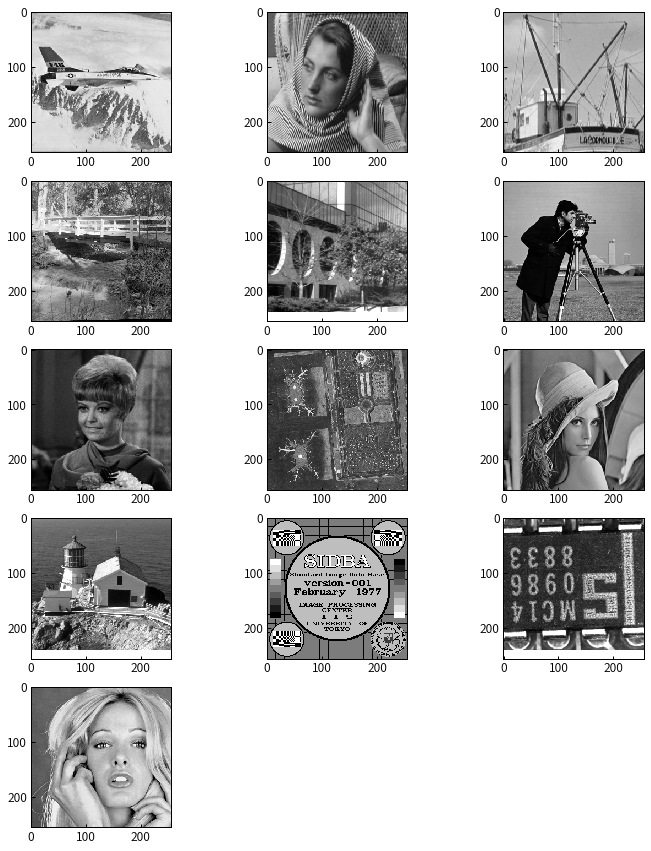

In [10]:
fig = plt.figure(figsize=(12,15))
for i in range(len(Images)):
    plt.subplot(len(Images)//3 + 1, 3 ,i+1)
    plt.imshow(Images[i].img,"gray")

# エネルギー

エネルギーはDCT後も保存され、信号列の2乗和とDCT係数の2乗和は等しくなる。

また、DCTにより、エネルギーは先頭(?)に集まることが見てわかる。

https://www.jstage.jst.go.jp/article/bplus/12/4/12_284/_pdf

ただし、信号にランチョス法を適用したものと、信号列のエネルギーは一致しない。

## 信号のエネルギーとDCT係数のエネルギー

### 信号列

In [91]:
data = LENNA.get_points(8).astype(np.uint64)
data

array([144, 145, 142, 140, 141, 138, 136, 138], dtype=uint64)

### 信号列のエネルギー

In [92]:
power = sum(np.power(data,2))
power

157990.0

### 信号列のDCT係数のエネルギー

In [93]:
dct = DCT(8)
c = dct.dct(data)
c

array([ 3.97394011e+02,  7.69756440e+00,  6.53281482e-01, -6.72830565e-02,
        7.07106781e-01, -2.77237722e+00, -2.70598050e-01,  2.38536782e-01])

In [94]:
power = sum(np.power(c,2))
power

157989.99999999994

### ランチョス法を適用した信号列のエネルギー

In [95]:
lanczos = Lanczos(data)
lanczos

array([144.        , 145.85714286, 143.71428571, 142.57142857,
       144.42857143, 142.28571429, 141.14285714, 144.        ])

In [96]:
power = sum(np.power(lanczos,2))
power

164752.85714285716

### ランチョス法を適用した信号列のDCT係数のエネルギー

In [97]:
dct = DCT(8)
c = dct.dct(lanczos)
c

array([ 4.05879292e+02,  2.17557324e+00,  6.53281482e-01, -6.44530029e-01,
        7.07106781e-01, -2.94457971e+00, -2.70598050e-01,  1.95077648e-01])

In [98]:
power = sum(np.power(c,2))
power

164752.8571428571

## logの場合

### 信号列のエネルギー

In [99]:
power = sum(np.log10(data))
power

17.180663068219587

In [101]:
dct = DCT(8)
c = dct.dct(data)
power = sum(np.log10(np.power(c,2)))
power

2.4615961055270024

## エネルギーの収束性

### 信号とランチョス法

信号のエネルギーとランチョス法を適用した信号のエネルギーは異なる

もちろん、それらのエネルギーと、それらをDCTし、得られたDCT係数のエネルギーは等しくなる。

では、信号->DCT、ランチョス->DCTでは、どちらの方がエネルギーが低周波に集中するのか。

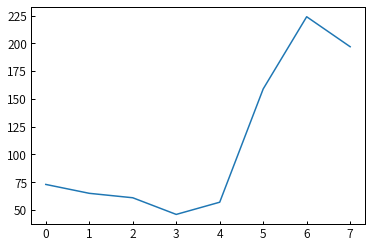

In [80]:
data = LENNA.get_points(8)
data_L = Lanczos(data)
plt.plot(data)

In [81]:
dct = DCT(8)
data_F = dct.dct(data)
data_L_F = dct.dct(data_L)

In [82]:
data_F_power = np.power(data_F,2)
data_L_F_power = np.power(data_L_F,2)

信号->DCT直流 [9.72405000e+04 2.40890451e+04 8.16249356e+03 2.27185672e+02
 2.31200000e+03 8.64040551e+02 6.43568654e-03 1.07286277e+01]

ランチョス->DCT [1.86245000e+04 1.68800262e+03 8.16249356e+03 7.29132329e+02
 2.31200000e+03 1.08592777e+03 6.43568654e-03 5.65156941e+00]


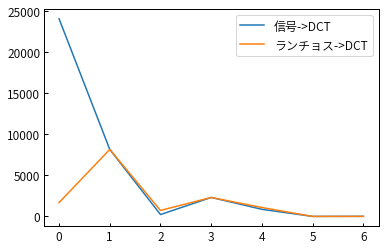

In [83]:
print("信号->DCT直流",data_F_power)
print("")
print("ランチョス->DCT",data_L_F_power)
plt.plot(data_F_power[1:],label="信号->DCT")
plt.plot(data_L_F_power[1:],label="ランチョス->DCT")
plt.legend()

直流成分は大きくなってる

交流成分の偶数個目は信号列のDCT係数とランチョス法のDCT係数が一致している。

**交流成分の1個目がとても小さくなってる**

2番目以降の差はほんとにちょっとだけ...？

In [42]:
data = LENNA.get_points(8)
data_L = Lanczos(data)

In [43]:
dct = DCT(8)
data_F = dct.dct(data)
data_L_F = dct.dct(data_L)

In [88]:
data_F_power = np.log10(np.abs(data_F))
data_L_F_power = np.log10(np.abs(data_L_F))

In [85]:
data_F_power[np.isnan(data_F_power)] = 0
data_L_F_power[np.isnan(data_L_F_power)] = 0

信号->DCT直流 [ 2.49392359  2.19090979  1.95591143  1.17819047  1.68199391  1.46826706
 -1.09570256  0.51527209]

ランチョス->DCT [ 2.13504231  1.61368656  1.95591143  1.43140318  1.68199391  1.51790047
 -1.09570256  0.37608453]


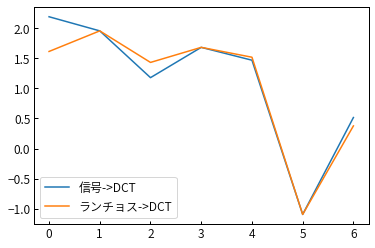

In [89]:
print("信号->DCT直流",data_F_power)
print("")
print("ランチョス->DCT",data_L_F_power)
plt.plot(data_F_power[1:],label="信号->DCT")
plt.plot(data_L_F_power[1:],label="ランチョス->DCT")
plt.legend()

信号->DCT直流 [ 2.49392359  2.19090979  1.95591143  1.17819047  1.68199391  1.46826706
 -1.09570256  0.51527209]

ランチョス->DCT [ 2.13504231  1.61368656  1.95591143  1.43140318  1.68199391  1.51790047
 -1.09570256  0.37608453]


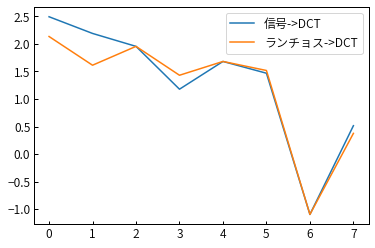

In [90]:
print("信号->DCT直流",data_F_power)
print("")
print("ランチョス->DCT",data_L_F_power)
plt.plot(data_F_power,label="信号->DCT")
plt.plot(data_L_F_power,label="ランチョス->DCT")
plt.legend()

# FFTとDCTの比較

DCTはDFTに比べて、エネルギーが低周波に集まることで知られている

https://ja.wikipedia.org/wiki/%E9%9B%A2%E6%95%A3%E3%82%B3%E3%82%B5%E3%82%A4%E3%83%B3%E5%A4%89%E6%8F%9B に書かれている

![](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Dandelion_clock_quarter_dft_dct.png/350px-Dandelion_clock_quarter_dft_dct.png)

それを確かめようと思う

図は右側が空間スペクトル、右がヒストグラムである

DCT係数はほとんどの値が小さいことがわかる

## 2次元DCT FFTを図示する

直流成分が大きすぎるので0埋めしておく

パワースペクトルは$20 \log_{10} V$だけど、値を正規化するので$\log_{10} V$で計算する

$\log_{10}$した後の値でマイナス値になる(1以下の数字)のは0だとする。(電圧値でいえば、$\simeq$ 0なので)

https://yaritakunai.hatenablog.com/entry/2016/03/20/235500

In [81]:
dct = DCT(256)
dct_F = dct.dct2(LENNA.img)

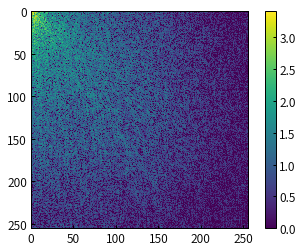

In [87]:
# dct_F1 = np.zeros((256,256))
dct_F1 = np.abs(dct_F)
dct_F1 = np.log10(dct_F1)
dct_F1[0,0] = 0
dct_F1[dct_F1 < 0] = 0
plt.imshow(dct_F1)
# plt.imshow(np.log10(np.abs(dct_F)))
plt.colorbar()

In [17]:
fft_F = np.fft.fft2(LENNA.img)

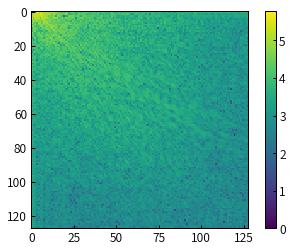

In [89]:
fft_F1 = np.abs(fft_F)
fft_F1 = np.log10(fft_F1)
fft_F1[0,0] = 0
fft_F1[0,255] = 0
fft_F1[255,0] = 0
fft_F1[255,255] = 0
plt.imshow(fft_F1[:128,:128])
plt.colorbar()

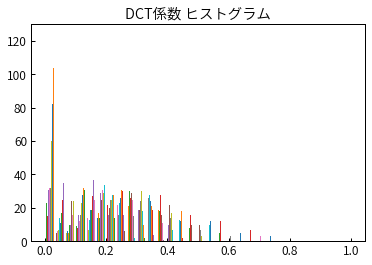

In [88]:
plt.hist(dct_F1/dct_F1.max(),bins=30)
plt.title("DCT係数 ヒストグラム")
plt.show()

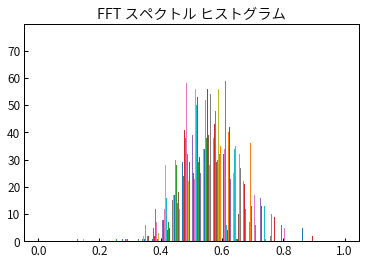

In [84]:
plt.hist(fft_F1/fft_F1.max(),bins=30)
plt.title("FFT スペクトル ヒストグラム")
plt.show()

それっぽい分布になった

FFTスペクトルに関しては、一部の象限のみ図示したがヒストグラムに用いるデータは4象限全てが対象

# AIRPLANE

## DCT, DCT+ランチョス

In [107]:
N = 8
dct = DCT(N)
LOOP_COUNT = 10000
AIRPLANE_F_DCT   = np.zeros(N)
AIRPLANE_F_DCT_L = np.zeros(N)

for i in tqdm(range(LOOP_COUNT)):
    data = AIRPLANE.get_points(N)
    data_L = Lanczos(data)
    
    AIRPLANE_F_DCT   += abs(dct.dct(data))
    AIRPLANE_F_DCT_L += abs(dct.dct(data_L))
    
AIRPLANE_F_DCT   /= LOOP_COUNT
AIRPLANE_F_DCT_L /= LOOP_COUNT

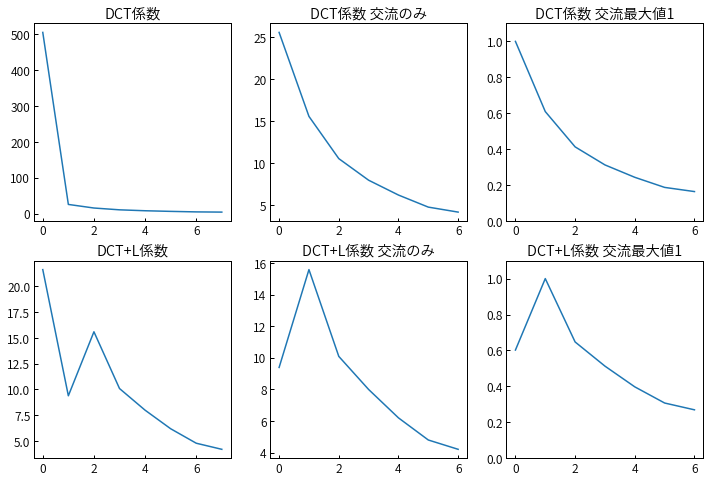

In [108]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(231)
ax1.plot(AIRPLANE_F_DCT)
ax1.title.set_text("DCT係数")

ax2 = fig.add_subplot(232)
ax2.plot(AIRPLANE_F_DCT[1:])
ax2.title.set_text("DCT係数 交流のみ")

ax3 = fig.add_subplot(233)
ax3.set_ylim(0,1.1)
ax3.plot(AIRPLANE_F_DCT[1:]/AIRPLANE_F_DCT[1:].max())
ax3.title.set_text("DCT係数 交流最大値1")

ax4 = fig.add_subplot(234)
ax4.plot(AIRPLANE_F_DCT_L)
ax4.title.set_text("DCT+L係数")

ax5 = fig.add_subplot(235)
ax5.plot(AIRPLANE_F_DCT_L[1:])
ax5.title.set_text("DCT+L係数 交流のみ")

ax6 = fig.add_subplot(236)
ax6.set_ylim(0,1.1)
ax6.plot(AIRPLANE_F_DCT_L[1:]/AIRPLANE_F_DCT_L[1:].max())
ax6.title.set_text("DCT+L係数 交流最大値1")

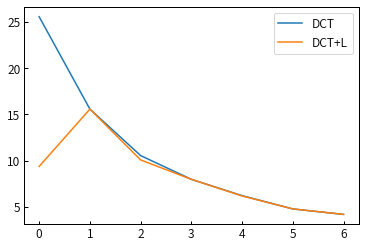

In [109]:
plt.plot(AIRPLANE_F_DCT[1:],label="DCT")
plt.plot(AIRPLANE_F_DCT_L[1:],label="DCT+L")
plt.legend()

# FFT

In [110]:
N = 16
LOOP_COUNT = 10000
AIRPLANE_F_FFT = np.zeros(N)

for i in tqdm(range(LOOP_COUNT)):
    AIRPLANE_F_FFT += abs(np.fft.fft(AIRPLANE.get_points(N)))
    
AIRPLANE_F_FFT /= LOOP_COUNT

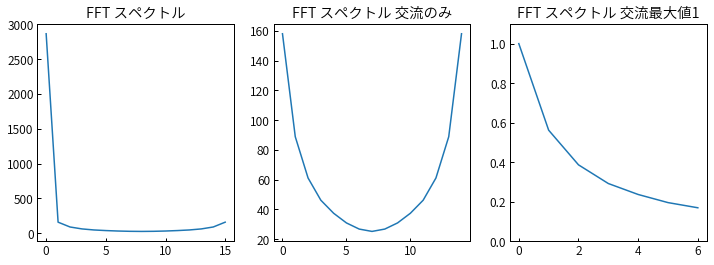

In [111]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax1.plot(AIRPLANE_F_FFT[:16])
ax1.title.set_text("FFT スペクトル")

ax2 = fig.add_subplot(132)
ax2.plot(AIRPLANE_F_FFT[1:16])
ax2.title.set_text("FFT スペクトル 交流のみ")

ax3 = fig.add_subplot(133)
ax3.set_ylim(0,1.1)
ax3.plot(AIRPLANE_F_FFT[1:N//2]/AIRPLANE_F_FFT[1:N//2].max())
ax3.title.set_text("FFT スペクトル 交流最大値1")

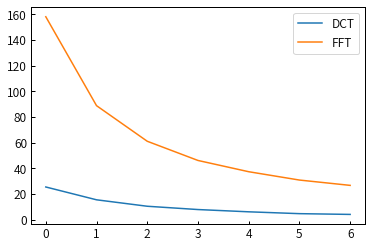

In [112]:
plt.plot(AIRPLANE_F_DCT[1:],label="DCT")
plt.plot(AIRPLANE_F_FFT[1:N//2],label="FFT")
plt.legend()

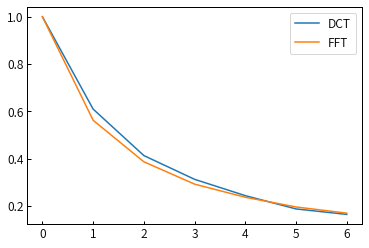

In [113]:
plt.plot(AIRPLANE_F_DCT[1:]/AIRPLANE_F_DCT[1:].max(),label="DCT")
plt.plot(AIRPLANE_F_FFT[1:N//2]/AIRPLANE_F_FFT[1:8].max(),label="FFT")
plt.legend()

# BARBARA

## DCT, DCT+ランチョス

In [100]:
N = 8
dct = DCT(N)
LOOP_COUNT = 10000
BARBAA_F_DCT   = np.zeros(N)
BARBARA_F_DCT_L = np.zeros(N)

for i in tqdm(range(LOOP_COUNT)):
    data = BARBARA.get_points(N)
    data_L = Lanczos(data)
    
    BARBARA_F_DCT   += abs(dct.dct(data))
    BARBARA_F_DCT_L += abs(dct.dct(data_L))
    
BARBARA_F_DCT   /= LOOP_COUNT
BARBARA_F_DCT_L /= LOOP_COUNT

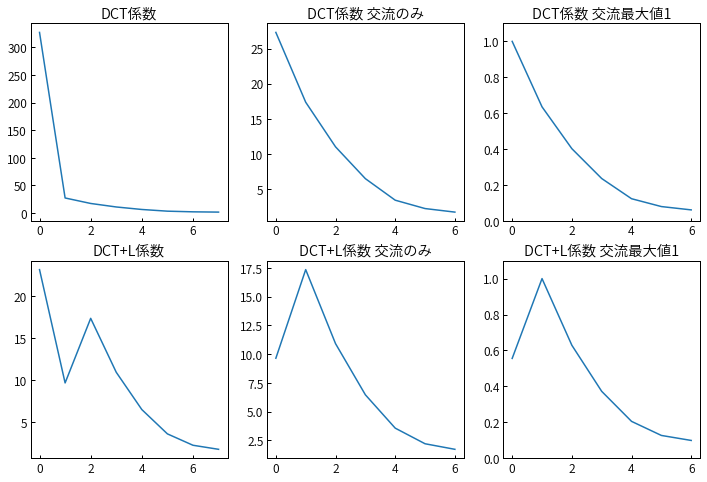

In [101]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(231)
ax1.plot(BARBARA_F_DCT)
ax1.title.set_text("DCT係数")

ax2 = fig.add_subplot(232)
ax2.plot(BARBARA_F_DCT[1:])
ax2.title.set_text("DCT係数 交流のみ")

ax3 = fig.add_subplot(233)
ax3.set_ylim(0,1.1)
ax3.plot(BARBARA_F_DCT[1:]/BARBARA_F_DCT[1:].max())
ax3.title.set_text("DCT係数 交流最大値1")

ax4 = fig.add_subplot(234)
ax4.plot(BARBARA_F_DCT_L)
ax4.title.set_text("DCT+L係数")

ax5 = fig.add_subplot(235)
ax5.plot(BARBARA_F_DCT_L[1:])
ax5.title.set_text("DCT+L係数 交流のみ")

ax6 = fig.add_subplot(236)
ax6.set_ylim(0,1.1)
ax6.plot(BARBARA_F_DCT_L[1:]/BARBARA_F_DCT_L[1:].max())
ax6.title.set_text("DCT+L係数 交流最大値1")

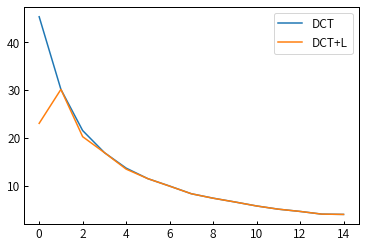

In [102]:
plt.plot(AIRPLANE_F_DCT[1:],label="DCT")
plt.plot(AIRPLANE_F_DCT_L[1:],label="DCT+L")
plt.legend()

# FFT

In [103]:
N = 16
LOOP_COUNT = 10000
BARBARA_F_FFT = np.zeros(N)

for i in tqdm(range(LOOP_COUNT)):
    BARBARA_F_FFT += abs(np.fft.fft(BARBARA.get_points(N)))
    
BARBARA_F_FFT /= LOOP_COUNT

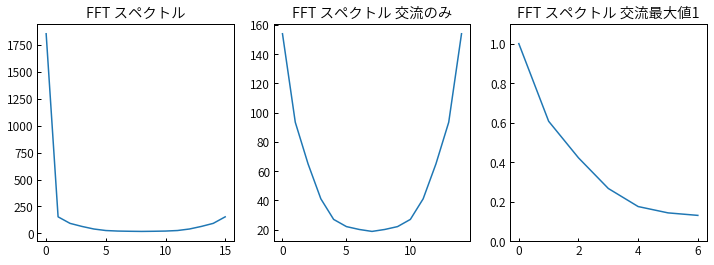

In [104]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax1.plot(BARBARA_F_FFT[:16])
ax1.title.set_text("FFT スペクトル")

ax2 = fig.add_subplot(132)
ax2.plot(BARBARA_F_FFT[1:16])
ax2.title.set_text("FFT スペクトル 交流のみ")

ax3 = fig.add_subplot(133)
ax3.set_ylim(0,1.1)
ax3.plot(BARBARA_F_FFT[1:N//2]/BARBARA_F_FFT[1:N//2].max())
ax3.title.set_text("FFT スペクトル 交流最大値1")

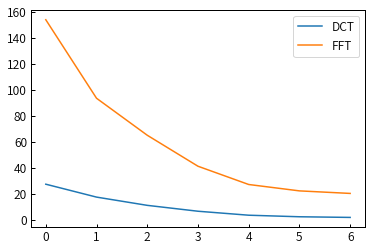

In [105]:
plt.plot(BARBARA_F_DCT[1:],label="DCT")
plt.plot(BARBARA_F_FFT[1:N//2],label="FFT")
plt.legend()

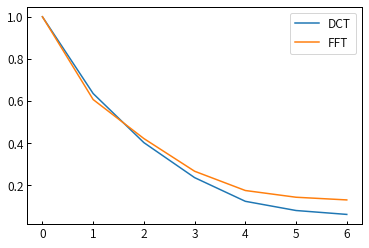

In [106]:
plt.plot(BARBARA_F_DCT[1:]/BARBARA_F_DCT[1:].max(),label="DCT")
plt.plot(BARBARA_F_FFT[1:N//2]/BARBARA_F_FFT[1:N//2].max(),label="FFT")
plt.legend()

## SIDBA title

## DCT

In [129]:
N = 8
dct = DCT(N)
LOOP_COUNT = 10000
SIDBAtitle_F_DCT   = np.zeros(N)
SIDBAtitle_F_DCT_L = np.zeros(N)

for i in tqdm(range(LOOP_COUNT)):
    data = SIDBAtitle.get_points(N)
    
    SIDBAtitle_F_DCT   += abs(dct.dct(data))
    
SIDBAtitle_F_DCT /= LOOP_COUNT

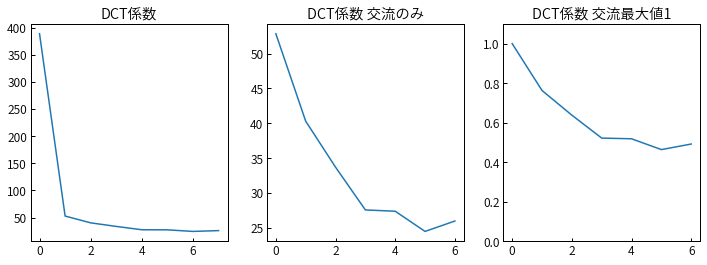

In [130]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax1.plot(SIDBAtitle_F_DCT)
ax1.title.set_text("DCT係数")

ax2 = fig.add_subplot(132)
ax2.plot(SIDBAtitle_F_DCT[1:])
ax2.title.set_text("DCT係数 交流のみ")

ax3 = fig.add_subplot(133)
ax3.set_ylim(0,1.1)
ax3.plot(SIDBAtitle_F_DCT[1:]/SIDBAtitle_F_DCT[1:].max())
ax3.title.set_text("DCT係数 交流最大値1")


# FFT

In [131]:
N = 16
LOOP_COUNT = 10000
SIDBAtitle_F_FFT = np.zeros(N)

for i in tqdm(range(LOOP_COUNT)):
    SIDBAtitle_F_FFT += abs(np.fft.fft(SIDBAtitle.get_points(N)))
    
SIDBAtitle_F_FFT /= LOOP_COUNT


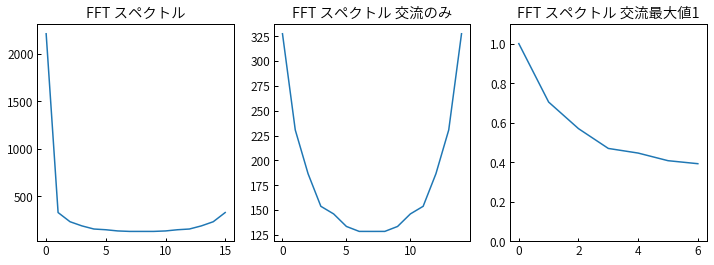

In [132]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax1.plot(SIDBAtitle_F_FFT[:16])
ax1.title.set_text("FFT スペクトル")

ax2 = fig.add_subplot(132)
ax2.plot(SIDBAtitle_F_FFT[1:16])
ax2.title.set_text("FFT スペクトル 交流のみ")

ax3 = fig.add_subplot(133)
ax3.set_ylim(0,1.1)
ax3.plot(SIDBAtitle_F_FFT[1:N//2]/SIDBAtitle_F_FFT[1:N//2].max())
ax3.title.set_text("FFT スペクトル 交流最大値1")


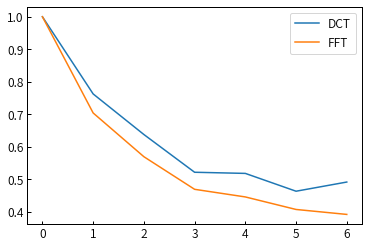

In [133]:
plt.plot(SIDBAtitle_F_DCT[1:]/SIDBAtitle_F_DCT[1:].max(),label="DCT")
plt.plot(SIDBAtitle_F_FFT[1:N//2]/SIDBAtitle_F_FFT[1:N//2].max(),label="FFT")
plt.legend()